In [1]:
# import required packages
from imodels import get_clean_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor, RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import RFPlusMDI
from sklearn.linear_model import RidgeCV, LogisticRegression
import shap
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set seed
np.random.seed(0)
# get pre-cleaned compas dataset from imodels
X, y, feature_names = get_clean_dataset('compas_two_year_clean', data_source='imodels')
X = pd.DataFrame(X, columns=feature_names)

In [3]:
# get proportion of X that has zero priors, 1-3 prior counts, and 4+ prior counts
bins = [-1, 0, 3, float('inf')]
labels = [0, 1, 2]
priors = pd.cut(X['priors_count'], bins=bins, labels=labels)
zero_priors = sum(priors == 0) / len(priors)
one_to_three_priors = sum(priors == 1) / len(priors)
four_plus_priors = sum(priors == 2) / len(priors)
print(f"Proportion of data with 0 priors: {zero_priors}")
print(f"Proportion of data with 1-3 priors: {one_to_three_priors}")
print(f"Proportion of data with 4+ priors: {four_plus_priors}")

Proportion of data with 0 priors: 0.3378159429682437
Proportion of data with 1-3 priors: 0.36876215165262477
Proportion of data with 4+ priors: 0.29342190537913154


/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


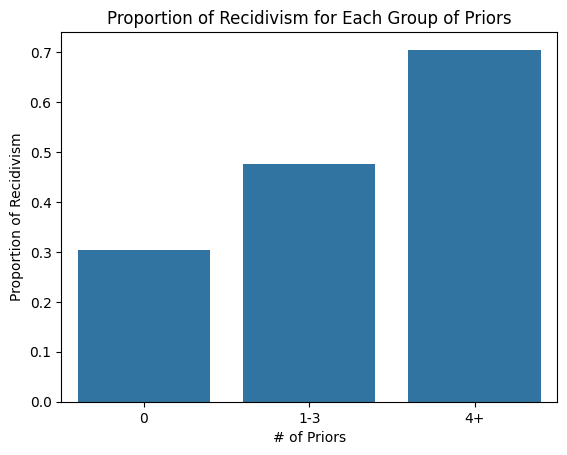

In [4]:
# plot proportion of y for each group of priors
df = pd.DataFrame({'priors': priors, 'recidivism': y})
df_prop = df.groupby('priors', observed=False)['recidivism'].mean().reset_index()
ax = sns.barplot(data=df_prop, x='priors', y='recidivism')
plt.xlabel('# of Priors')
plt.ylabel('Proportion of Recidivism')
plt.title('Proportion of Recidivism for Each Group of Priors')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["0", "1-3", "4+"])
plt.show()

In [5]:
# split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=2)

In [6]:
# fit RF model
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# fit RF+ model
rf_plus = RandomForestPlusClassifier(rf_model = rf, prediction_model = LogisticRegression())
rf_plus.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.4s finished


In [7]:
# get TreeSHAP importances and rankings
explainer = shap.TreeExplainer(rf)
shap_values = np.abs(explainer.shap_values(X_train, check_additivity=False))[:,:,1]
shap_rankings = np.argsort(-shap_values, axis = 1)

In [8]:
# get LMDI+ importances and rankings
rfplus_explainer = RFPlusMDI(rf_plus)
lmdi_values = np.abs(rfplus_explainer.explain_linear_partial(np.asarray(X_train), y_train, l2norm=True, njobs = 1))
lmdi_rankings = rfplus_explainer.get_rankings(lmdi_values)

In [9]:
# sort based highest y to lowest y
sorted_indices = np.argsort(-y_train)
sorted_lmdi_values = lmdi_values[sorted_indices]
sorted_lmdi_rankings = lmdi_rankings[sorted_indices]
sorted_shap_values = shap_values[sorted_indices]
sorted_shap_rankings = shap_rankings[sorted_indices]

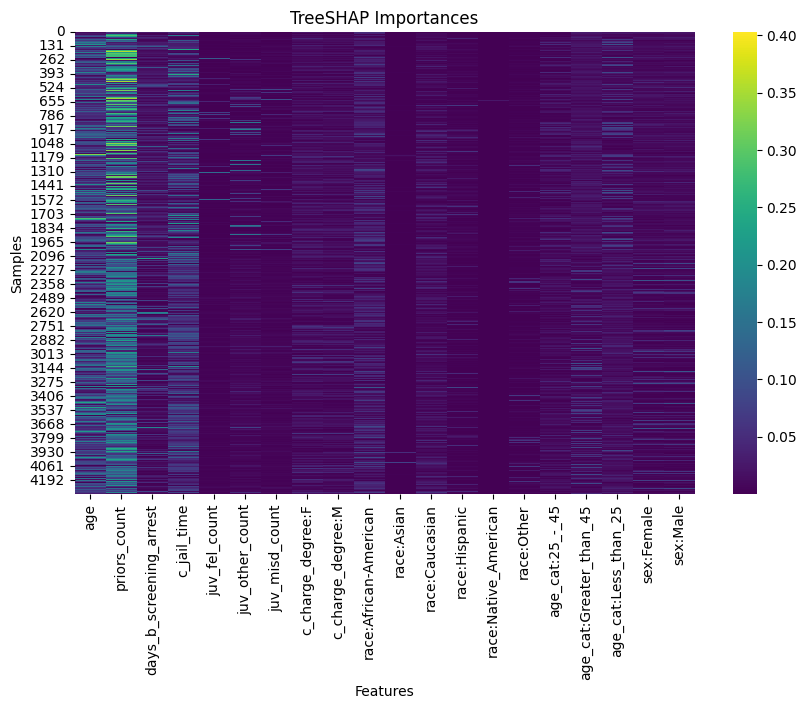

In [10]:
# plot heatmap of LMDI+ importances based on true y
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_shap_values, cmap='viridis')
plt.title('TreeSHAP Importances')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.xticks(ticks = np.arange(X_train.shape[1]) + 0.5, labels = X_train.columns, rotation = 90)
plt.show()

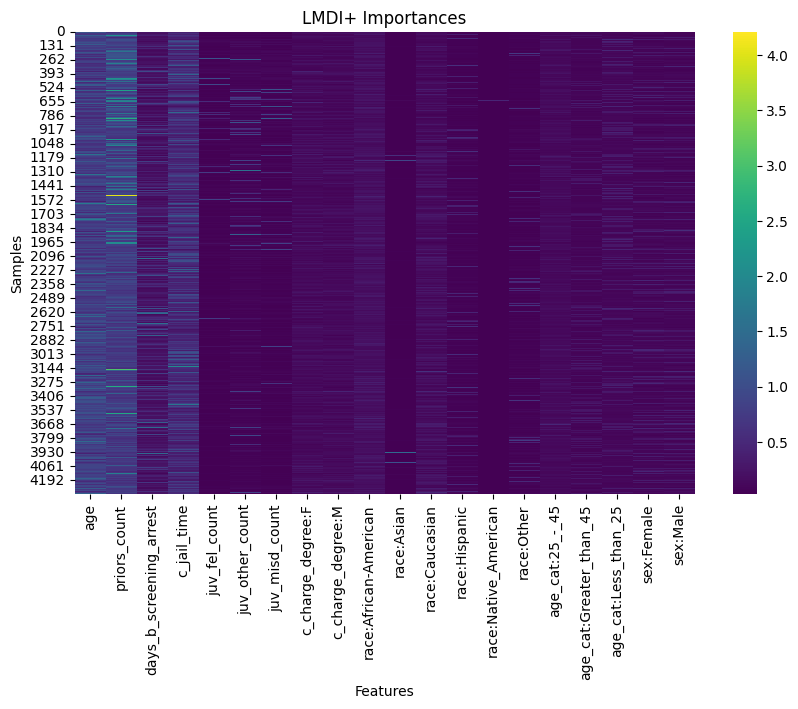

In [11]:
# plot heatmap of LMDI+ importances based on true y
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_lmdi_values, cmap='viridis')
plt.title('LMDI+ Importances')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.xticks(ticks = np.arange(X_train.shape[1]) + 0.5, labels = X_train.columns, rotation = 90)
plt.show()

In [8]:
lmdi_sub_imp = pd.concat([X_train["priors_count"].reset_index(drop=True), pd.DataFrame(lmdi_rankings)], axis=1)
# define subgroup bins and labels
bins = [-1, 0, 3, float('inf')]
labels = [0, 1, 2]
lmdi_sub_imp["priors_count"] = pd.cut(X['priors_count'], bins=bins, labels=labels)

In [16]:
shap_sub_imp = pd.concat([X_train["priors_count"].reset_index(drop=True), pd.DataFrame(shap_rankings)], axis=1)
# define subgroup bins and labels
bins = [-1, 0, 3, float('inf')]
labels = [0, 1, 2]
shap_sub_imp["priors_count"] = pd.cut(X['priors_count'], bins=bins, labels=labels)

In [14]:
lmdi_mean_rankings = lmdi_sub_imp.groupby('priors_count', observed=False).mean().reset_index()
# rank features for each row
lmdi_ranked_mean_rankings = lmdi_mean_rankings.drop(columns=["priors_count"]).rank(axis=1)
lmdi_ranked_mean_rankings.columns = X.columns
lmdi_ranked_mean_rankings

,age,priors_count,days_b_screening_arrest,c_jail_time,juv_fel_count,juv_other_count,juv_misd_count,c_charge_degree:F,c_charge_degree:M,race:African-American,race:Asian,race:Caucasian,race:Hispanic,race:Native_American,race:Other,age_cat:25_-_45,age_cat:Greater_than_45,age_cat:Less_than_25,sex:Female,sex:Male
0,1.0,2.0,3.0,4.0,9.0,11.0,8.0,10.0,13.0,15.0,18.0,20.0,19.0,16.0,14.0,12.0,7.0,5.0,6.0,17.0
1,1.0,2.0,3.0,4.0,8.0,10.0,9.0,12.0,13.0,15.0,18.0,20.0,19.0,16.0,14.0,11.0,6.0,5.0,7.0,17.0
2,1.0,2.0,3.0,4.0,8.0,9.0,10.0,12.0,13.0,15.0,18.0,19.0,20.0,16.0,14.0,11.0,7.0,5.0,6.0,17.0


In [17]:
shap_mean_rankings = shap_sub_imp.groupby('priors_count', observed=False).mean().reset_index()
# rank features for each row
shap_ranked_mean_rankings = shap_mean_rankings.drop(columns=["priors_count"]).rank(axis=1)
shap_ranked_mean_rankings.columns = X.columns
shap_ranked_mean_rankings

,age,priors_count,days_b_screening_arrest,c_jail_time,juv_fel_count,juv_other_count,juv_misd_count,c_charge_degree:F,c_charge_degree:M,race:African-American,race:Asian,race:Caucasian,race:Hispanic,race:Native_American,race:Other,age_cat:25_-_45,age_cat:Greater_than_45,age_cat:Less_than_25,sex:Female,sex:Male
0,1.0,2.0,3.0,4.0,7.0,12.0,16.0,18.0,17.0,19.0,15.0,14.0,11.0,9.0,6.0,5.0,8.0,10.0,13.0,20.0
1,1.0,2.0,3.0,4.0,5.0,11.0,15.0,16.0,17.0,19.0,18.0,14.0,12.0,10.0,7.0,6.0,8.0,9.0,13.0,20.0
2,1.0,2.0,3.0,4.0,5.0,12.0,14.0,17.0,18.0,19.0,16.0,15.0,11.0,10.0,9.0,6.0,7.0,8.0,13.0,20.0
